# IP signage

Ok, so in the process of switching frameworks, idk if I did enough validation, so I want to go back and check this.

For example, when I was training network's with Dan's setup, I *thought* I was using the same inputs, but I might not have been.

In particular, there are some different ways that we can think about for defining the signage for ip3d, either using the 3d lifetime sign, or the 2d signages in the transverse and $r\phi-z$ planes.

It was confusing to me that the jet_trk_ip3d_d0sig used the 3d lifetime signage and jet_trk_ip3d_z0sig uses the 2d lifetime signage, so I wasn't 100% sure if Dan was doing the same thing or not.

I.e, for notation the `mc16d_PFlow_ttbar` are the files that were processed from the performanc framework, while the `mc16d_PFlow_ttbar_ip3d` are the files w/ the same track selections that were processed with the training dataset dumper.

In [1]:
import numpy as np
import h5py
import sys
import os
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

sys.path.append("../../../track_extrapolator/")
from file_loading import *
from helper_functions import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Load in a dataset from the performance framework

subDir_pf = 'mc16d_PFlow_ttbar'
dataDir = '../../data/'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTest  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_pf,dataTagTest)
f = h5py.File(f_name,"r")

X_pf = f['X_test'][:]
y_pf = f['y_test'][:]
ix_pf = f['ix_test'][:]

f.close()

mask_pf = getTrkMask(X_pf)

In [3]:
# Load in a dataset from the Ntuple dumper

subDir_h5 = 'mc16d_PFlow_ttbar_ip3d'

f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_h5,dataTagTest)
f = h5py.File(f_name,"r")

X_h5 = f['X_test'][:]
y_h5 = f['y_test'][:]
ix_h5 = f['ix_test'][:]

f.close()

mask_h5 = getTrkMask(X_h5)

Compare the $s_{d0}$ distributions

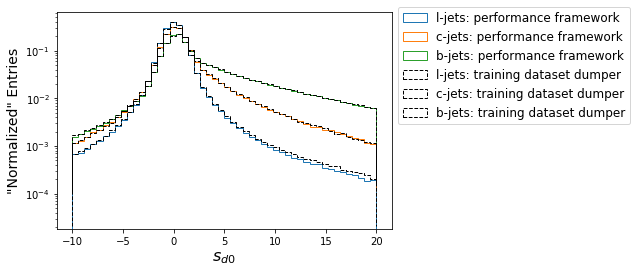

In [4]:
for X, y, mask, s, fw in zip([X_pf,X_h5],[y_pf,y_h5],[mask_pf,mask_h5],['-','--'],['performance framework','training dataset dumper']):
    for yi,(c,f) in enumerate(zip(['C0','C1','C2'],['l','c','b'])):
        plt.hist(X[:,:,0][(y==yi).reshape(-1,1) & mask], 
                 50,(-10,20),histtype='step',linestyle=s,
                 color= c if s =='-' else 'k',label=f+'-jets: '+fw,
                 log=True,density=True)

plt.xlabel('$s_{d0}$', fontsize=16)
plt.ylabel('"Normalized" Entries', fontsize=14)
plt.legend(fontsize=12,bbox_to_anchor=(1,1.05))
plt.savefig("../../figures/{}/sd0_cf_opt_fw.pdf".format(subDir_h5),bbox_inches='tight')

plt.show()

Compare the $s_{z0}$ distributions

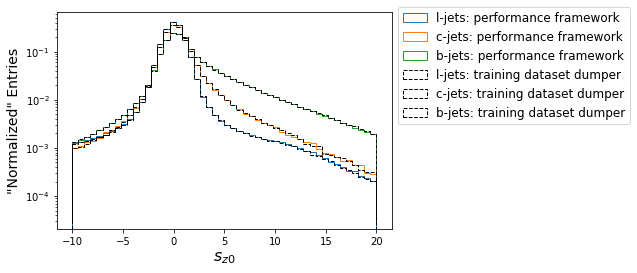

In [ ]:
for X,y,mask,s,fw in zip([X_pf,X_h5],[y_pf,y_h5],[mask_pf,mask_h5],['-','--'],['performance framework','training dataset dumper']):
    for yi,(c,f) in enumerate(zip(['C0','C1','C2'],['l','c','b'])):
        plt.hist(X[:,:,1][(y==yi).reshape(-1,1) & mask], 
                 50,(-10,20),histtype='step',linestyle=s,
                 color = c if s =='-' else 'k', label=f+'-jets: '+fw,
                 log=True,density=True)

plt.xlabel('$s_{z0}$', fontsize=16)
plt.ylabel('"Normalized" Entries', fontsize=14)
plt.legend(fontsize=12,bbox_to_anchor=(1,1.05))

plt.savefig("../../figures/{}/sz0_cf_opt_fw.pdf".format(subDir_h5),bbox_inches='tight')

plt.show()

Ok, from the distribution standpoint, they seem to be doing the same thing. 

This was also confirmed by Dan sending me where the [EDM IP signage was calculated](https://gitlab.cern.ch/atlas/athena/blob/21.2/PhysicsAnalysis/JetTagging/FlavorTagDiscriminants/Root/BTagTrackAugmenter.cxx), where the [ReadMe](https://gitlab.cern.ch/atlas/athena/tree/21.2/PhysicsAnalysis/JetTagging/FlavorTagDiscriminants#package-overview) describes how these tools all interact w/ eachother.

# Plan

I want to test out whether 2d or 3d signage works out best for DIPS, so I added the jet_trk_ip2d_d0 signage to the dfs that I'm printing saving with `root_to_np.py`, and I'll do the pre-processing here and then submit some trainings to evaluate the performance!

| $d_0$ signage | $z_0$ signage |      Description      |
| ------------- | ------------- | --------------------- |
| 3d            | 2d            |      What we have now |
| 2d            | 2d            | Giacinto's suggestion |
| 3d            | 3d            |  Su Dong's suggestion |
| 2d            | 3d            |      For completeness |

**Step 1:** I think I should compare the 2d and 3d signage for the HF tracks in b-jets, and for completeness I can do this for the 2d and 3d signages as well.

*Agh!* I can't do this with the current dataset ;(

In [3]:
dataDir = "../../data"
figDir = '../../figures/'

subDir_jf = 'mc16d_PFlow_ttbar_jf'

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nTrks=40
dataTagTrain = "3mtrain_{}trks_{}_sd0_rev".format(nTrks,vStr)
dataTagTest  = "2mtest_{}trks_{}_sd0_rev".format(nTrks,vStr)

'''
train
'''
f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_jf,dataTagTrain)
f = h5py.File(f_name,"r")

X_tr  = f['X_train'][:]
y_tr  = f['y_train'][:]
ix_tr = f['ix_train'][:]
w_tr  = f['weights_train'][:]

f.close()


'''
test
'''
f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_jf,dataTagTest)
f = h5py.File(f_name,"r")

X_te = f['X_test'][:]
y_te = f['y_test'][:]
ix_te = f['ix_test'][:]

f.close()


jet_df_tr = pd.read_hdf('{}/{}/jet_3mtrain_{}trks.h5'.format(dataDir,subDir_jf,nTrks), key='jet_df')

trk_xr_tr = xr.open_dataarray('{}/{}/trk_3mtrain_{}trks.nc'.format(dataDir,subDir_jf,nTrks))
trk_xr_te = xr.open_dataarray('{}/{}/trk_2mtest_{}trks.nc'.format(dataDir,subDir_jf,nTrks))

In [ ]:
for c in trk_xr_tr.coords['var'].values:
    print(c)

chiSquared
numberDoF
IP3D_signed_d0
IP2D_signed_d0
IP3D_signed_z0
sd0
sz0
IP2D_grade
IP3D_grade
nInnHits
nNextToInnHits
nsharedBLHits
nsplitBLHits
nPixHits
numberOfPixelHoles
nsharedPixHits
nsplitPixHits
nSCTHits
numberOfSCTHoles
nsharedSCTHits
pt
eta
deta
dphi
dr
ptfrac


In [5]:
bjets = (jet_df_tr.LabDr_HadF == 5)

d0_3d = trk_xr_tr.loc[:,:,'IP3D_signed_d0'].values[bjets]
d0_2d = trk_xr_tr.loc[:,:,'IP2D_signed_d0'].values[bjets]

z0_2d = trk_xr_tr.loc[:,:,'IP2D_signed_d0'].values[bjets]


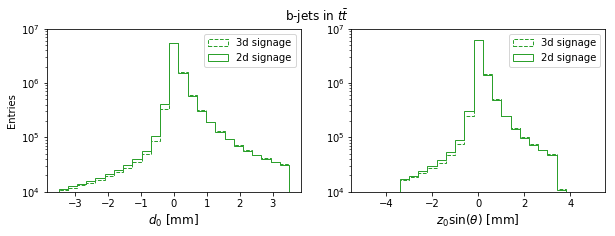

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,3))

mask = (d0_3d != 0) & (z0_2d != 0) 
ylim = (1e4,1e7)

ax0.hist(d0_3d[mask],25,(-3.5,3.5),label='3d signage',
         histtype='step',color='C2',linestyle='--',log=True)
ax0.hist(d0_2d[mask],25,(-3.5,3.5),label='2d signage',
         histtype='step',color='C2',log=True)
ax0.set_xlabel('$d_0$ [mm]',fontsize=12)
ax0.set_ylabel('Entries')
ax0.set_ylim(ylim)
ax0.legend()

ax1.hist(np.sign(d0_3d[mask])*np.abs(z0_2d[mask]),25,(-5,5),
         label='3d signage',
         histtype='step',color='C2',linestyle='--',log=True)
ax1.hist(z0_2d[mask],25,(-5,5),label='2d signage',
         histtype='step',color='C2',log=True)
ax1.set_xlabel(r'$z_0 \sin ( \theta )$ [mm]',fontsize=12)
ax1.set_ylim(ylim)
ax1.legend()

plt.suptitle(r'b-jets in $t\bar{t}$')

plt.savefig("../../figures/{}/IP_signage.pdf".format(subDir_jf),bbox_inches='tight')

plt.show()

When we look at all the tracks in b-jets, it seems like the 3d signage is better, maybe the story would change if I was able to just look at the HF tracks though.

**I could try this out w/ the flavor tag performance framework Ntuples!**

**Step 2:** Do the pre-processing manually

In [ ]:
for tag in ["2dsign","3dsign","2d_d0_3d_z0"]:
    
    for b in ["data","figures","models"]:
        
        myDir = "../../{}/{}_{}".format(b,subDir_pf,tag)
        
        #if not os.path.exists(myDir):
        print("creating",myDir)
    
            #os.mkdir(myDir)

creating ../../data/mc16d_PFlow_ttbar_2dsign
creating ../../figures/mc16d_PFlow_ttbar_2dsign
creating ../../models/mc16d_PFlow_ttbar_2dsign
creating ../../data/mc16d_PFlow_ttbar_3dsign
creating ../../figures/mc16d_PFlow_ttbar_3dsign
creating ../../models/mc16d_PFlow_ttbar_3dsign
creating ../../data/mc16d_PFlow_ttbar_2d_d0_3d_z0
creating ../../figures/mc16d_PFlow_ttbar_2d_d0_3d_z0
creating ../../models/mc16d_PFlow_ttbar_2d_d0_3d_z0


In [4]:
def saveFile(f_name,X,y,ix,w,mode):
   
    f = h5py.File(f_name,"w")

    f.create_dataset("X_"+mode, data=X)
    f.create_dataset("y_"+mode, data=y)
    f.create_dataset("ix_"+mode,data=ix)
    if mode == "train":
        f.create_dataset("weights_"+mode, data=w)
    
    f.close()

In [5]:
baseDir = "{}/{}".format(dataDir,subDir_pf)

for X,y,ix,w,trk_xr,dataTag,mode in zip([X_tr,X_te],
                                        [y_tr,y_te],
                                        [ix_tr,ix_te],
                                        [w_tr,None],
                                        [trk_xr_tr,trk_xr_te],
                                        [dataTagTrain,dataTagTest],
                                        ['train','test']):
    
    if mode == 'train':
        continue
    
    d0_3d = trk_xr.loc[:,:,'IP3D_signed_d0'].values
    d0_2d = trk_xr.loc[:,:,'IP2D_signed_d0'].values

    z0_2d = trk_xr.loc[:,:,'IP2D_signed_d0'].values
    
    
    tag = "2dsign"
    print(tag)
    # Need to just update the d0 signage
    Xnew = X.copy()
    Xnew[:,:,0] = np.sign(d0_2d)*np.abs(Xnew[:,:,0])
    
    f_name = "{}_{}/data_{}.hdf5".format(baseDir,tag,dataTag)
    saveFile(f_name,Xnew,y,ix,w=w,mode=mode)

    
    
    tag = "3dsign"
    print(tag)
    # Just need to update the z0 signage
    Xnew = X.copy()
    Xnew[:,:,1] = np.sign(d0_3d)*np.abs(Xnew[:,:,1])
    
    f_name = "{}_{}/data_{}.hdf5".format(baseDir,tag,dataTag)
    saveFile(f_name,Xnew,y,ix,w,mode)
    
    tag = "2d_d0_3d_z0"
    print(tag)
    # Update both the d0 AND z0 signage
    Xnew = X.copy()
    Xnew[:,:,0] = np.sign(d0_2d)*np.abs(Xnew[:,:,0])
    Xnew[:,:,1] = np.sign(d0_3d)*np.abs(Xnew[:,:,1])
    
    f_name = "{}_{}/data_{}.hdf5".format(baseDir,tag,dataTag)
    saveFile(f_name,Xnew,y,ix,w=w,mode=mode)
    
    #break

2dsign
3dsign
2d_d0_3d_z0


**Step 3:** Evaluate the trained taggers

In [4]:
modelDir = "../../models/"

dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

(1500000, 40, 13)
Initialize method from myModel()
Instructions for updating:
Colocations handled automatically by placer.
weightFile ../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


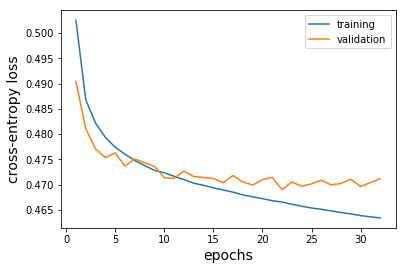

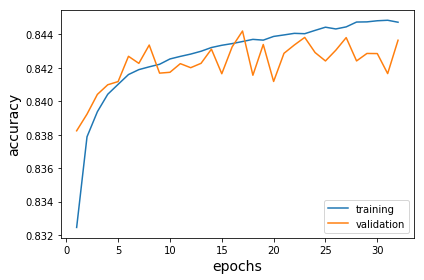

../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
(1500000, 40, 13)
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_3dsign/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


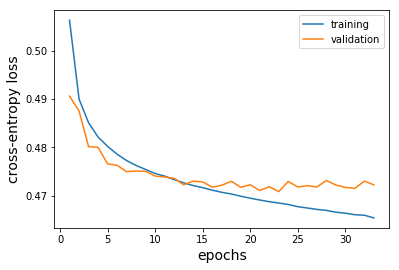

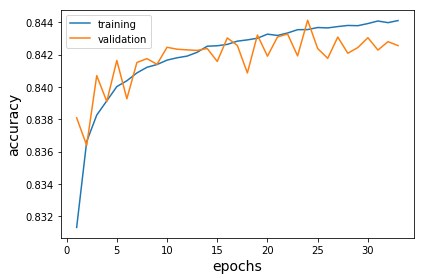

../../models/mc16d_PFlow_ttbar_3dsign/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
(1500000, 40, 13)
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_2dsign/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


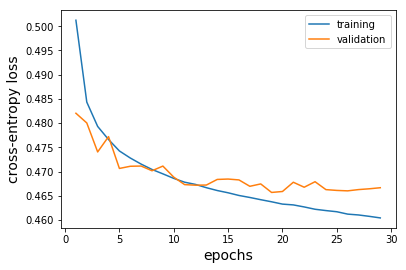

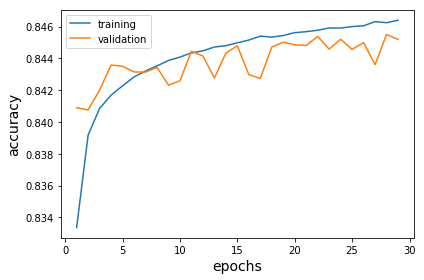

../../models/mc16d_PFlow_ttbar_2dsign/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
(1500000, 40, 13)
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_2d_d0_3d_z0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


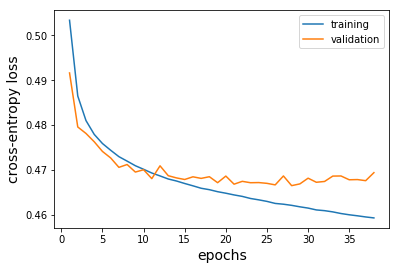

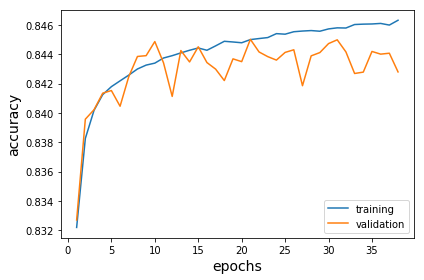

../../models/mc16d_PFlow_ttbar_2d_d0_3d_z0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file


In [5]:
tags = ["_pt_0.5_d0_3.5_z0_5.0","_3dsign","_2dsign","_2d_d0_3d_z0"]

sortFlags = ["abs_sd0_rev"]+["sd0_rev"]*3

labels = ["3d $d_0$ sign, 2d $z_0$ sign",
          "2d $d_0$ and $z_0$ sign",
          "3d $d_0$ and $z_0$ sign",
          "2d $d_0$ sign, 3d $z_0$ sign"]

leffs, ceffs, beffs = [],[],[]

for tag,sortFlag in zip(tags,sortFlags):
    
    '''
    Load in the data
    '''
    subDir = subDir_pf+tag
      
    dataTagTrain = "3mtrain_{}trks_{}".format(nTrks,vStr,sortFlag)
    dataTagTest  = "2mtest_{}trks_{}_{}".format(nTrks,vStr,sortFlag)
    
    
    f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir,dataTagTest)
    f = h5py.File(f_name,"r")

    #     else:
    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()

    print(X.shape)

    nFeatures = X.shape[-1]

    '''
    Load in the model
    '''
    dips = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                modelDir=modelDir+subDir, dataTag=dataTagTrain, nClasses=3, 
                loadModel=True, dropout=0,batch_norm=True)

    trainingMetrics(dips.modelName, modelDir+subDir)

    '''
    Evaluate the taggers
    '''
    leff, ceff, beff = getEffs(dips, X, y, ix, figDir=figDir,
                               subDir=subDir, modelDir=modelDir+subDir)
        
    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)


Draw the ROC curves.

In [6]:
subDir_jf

'mc16d_PFlow_ttbar_jf'

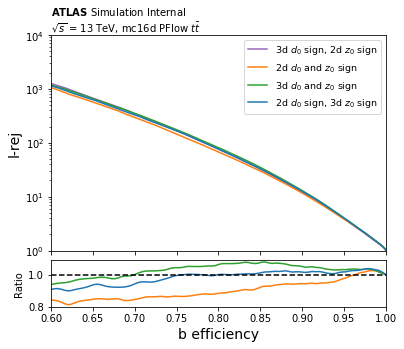

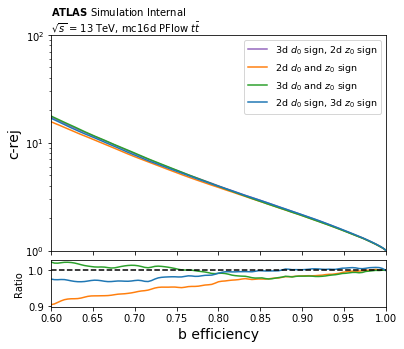

In [9]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

colors = ['C4','C1','C2','C0']

plotROCRatio(beffs, leffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='l-rej',ymax=1e4,
             figDir=figDir,subDir=subDir_jf,tag='_lrej_IPsignage')
plotROCRatio(beffs, ceffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='c-rej',ymax=100,
             figDir=figDir,subDir=subDir_jf,tag='_crej_IPsignage')

**Conclusions:**

There really isn't much of difference between the green and the purple lines, so I guess the solution is to keep whatever the default was.
